In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

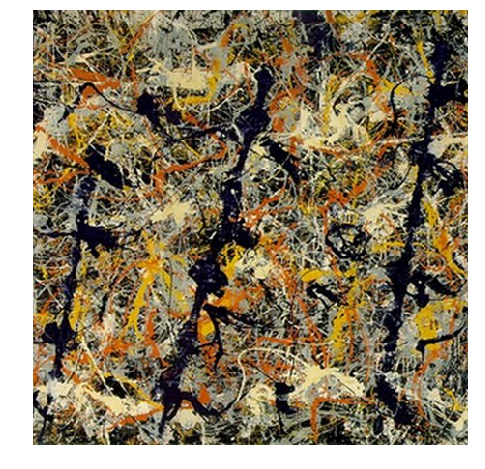

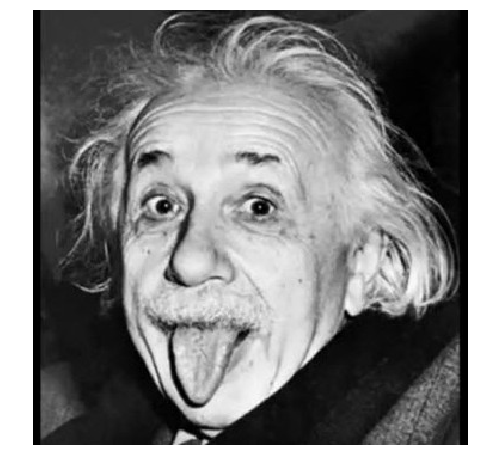

In [2]:
toImage = transforms.ToPILImage()

def image_load(image_name, **kwargs):
    image = Image.open(image_name)
    if 'resize' in kwargs:
        resize = transforms.Scale(kwargs['resize'])
        image = resize(image)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
    image = Variable(transform(image),volatile=True)
    image = image.unsqueeze(0) 
    return image

def image_show(img):
    img=toImage(img[0].data * 0.5 + 0.5)
    plt.imshow(img,aspect=None)
    plt.axis('off')
    plt.gcf().set_size_inches(8, 8)
    plt.show()

def image_save(img, path):
    img=toImage(img[0].data * 0.5 + 0.5)
    img.save(path)
    
style_image = image_load("./images/pollok.jpg")
content_image = image_load("./images/einstein.jpg")

image_show(style_image)
image_show(content_image)

In [3]:
def extract_features(image, layers, model):
    features = []
    for i in range(layers[-1] + 1):
        image = model[i](image)
        if i in layers :
            features.append(image)       
    return features

In [4]:
def get_gram(feature):
    n, f, h, w = feature.size()
    feature = feature.resize(n * f, h * w)
    gram = torch.mm(feature, feature.t()).div(n * f * h * w)
    return gram

In [5]:
class Stylize(nn.Module):
    def forward(self, image):
        style_features = extract_features(image, style_layer, model)
        style_features = [get_gram(style_feature) for style_feature in style_features]
        content_features = extract_features(image, content_layer, model)
        return style_features, content_features

In [6]:
def totalloss(style_target_features, content_target_features, style_features, content_features, style_weight, content_weigh):
    l2loss = nn.MSELoss(size_average=False)
    style_loss = [l2loss(style_features[i], style_target_features[i]) for i in range(len(style_features))] 
    mean_loss = sum(style_loss).data[0] / len(style_features)
    
    style_loss = sum([(mean_loss/l.data[0]) * l * style_layer_weights[i] 
                    for i,l in enumerate(style_loss)]) / len(style_features) 
    
    content_loss = sum([l2loss(content_features[i], content_target_features[i]) 
                    for i in range(len(content_target_features))]) / len(content_features)
    
    total_loss = style_weight * style_loss + content_weight * content_loss
    return total_loss

In [7]:
def get_target_features(style_image, content_image, model):
    style_features = extract_features(style_image, style_layer, model)
    style_features = [get_gram(style_feature) for style_feature in style_features]
    style_features = [Variable(style_feature.data) for style_feature in style_features]
    content_features = extract_features(content_image, content_layer, model)
    content_features = [Variable(content_feature.data) for content_feature in content_features]
    return style_features, content_features

In [8]:
# initiate parameters
learning_rate = 1e-1
style_weight = 1
content_weight = 1e-3
num_iters = 400
showing_image = 100

style_layer =[1, 3, 4, 5, 6, 7, 8, 9]
style_layer_weights = [40, 40, 1, 1, 1, 10, 10, 10]
content_layer = [1, 2, 3]

Total loss: 551160.4375


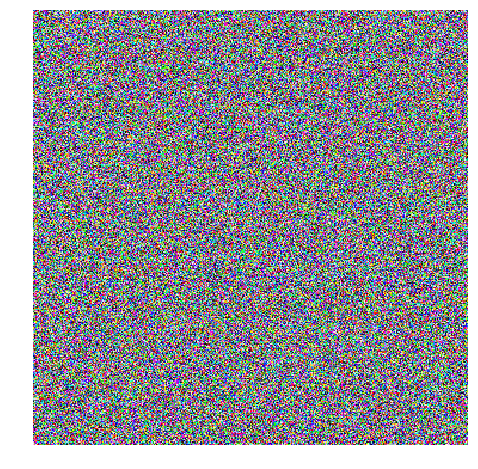

Total loss: 782.0283203125


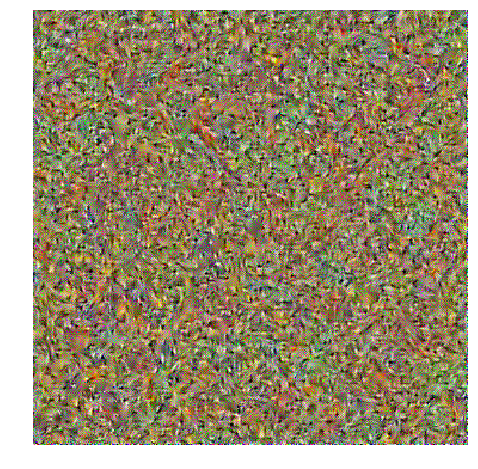

Total loss: 776.5115966796875


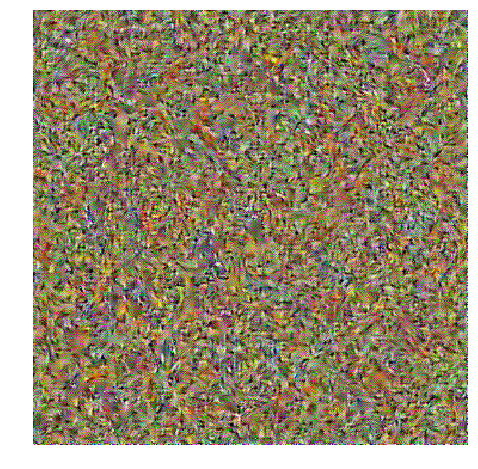

Total loss: 875.632080078125


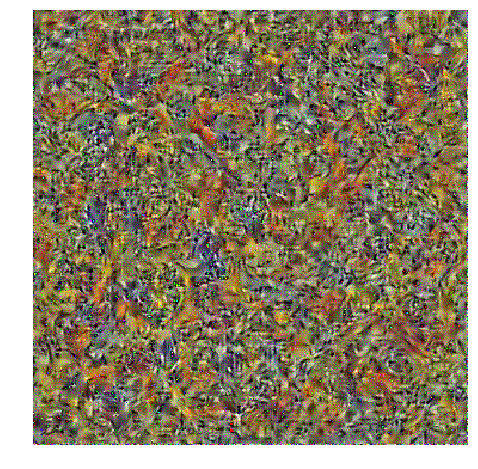

In [ ]:
# load model
model = models.squeezenet1_1(pretrained=True)
model = next(model.children())

# initiate image from noise
train_image = Variable(torch.randn(content_image.size()), requires_grad = True)

# optimizer
optimizer = optim.Adam([train_image], lr=learning_rate)

# forward
style_target_features, content_target_features = get_target_features(style_image, content_image, model)

stylize = Stylize()

for i in range(num_iters):
    
    optimizer.zero_grad()

    train_image.data.clamp_(-1, 1)  # useful at first several step

    style_features, content_features = stylize(train_image)

    loss = totalloss(style_target_features, content_target_features, style_features, content_features, style_weight, content_weight)

    loss.backward()

    optimizer.step()
     
    if i % showing_image == 0:
        print("Total loss: {}".format(loss.data[0]))
        image_show(train_image)

Total loss: 958.5592041015625


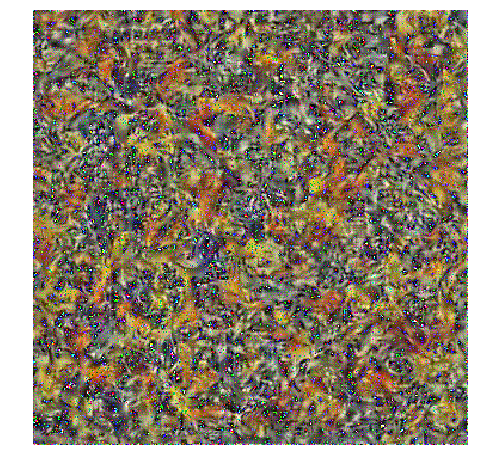

In [ ]:
# decrease learning rate and continue
optimizer = optim.Adam([train_image], lr=learning_rate / 5)

for i in range(num_iters):
    
    optimizer.zero_grad()

    train_image.data.clamp_(-1, 1)  # useful at first several step

    style_features, content_features = stylize(train_image)

    loss = totalloss(style_target_features, content_target_features, style_features, content_features, style_weight, content_weight)

    loss.backward()

    optimizer.step()
     
    if i % showing_image == 0:
        print("Total loss: {}".format(loss.data[0]))
        image_show(train_image)

In [ ]:
# decrease learning rate and continue
optimizer = optim.Adam([train_image], lr=learning_rate / 10)

for i in range(num_iters):
    
    optimizer.zero_grad()

    train_image.data.clamp_(-1, 1)  # useful at first several step

    style_features, content_features = stylize(train_image)

    loss = totalloss(style_target_features, content_target_features, style_features, content_features, style_weight, content_weight)

    loss.backward()

    optimizer.step()
     
    if i % showing_image == 0:
        print("Total loss: {}".format(loss.data[0]))
        image_show(train_image)

In [ ]:
image_show(train_image)
image_save(train_image, "./images/stylized.jpg")